# Aurora Forecasting - Part 04: Actionable Batch Inference

🗒️ This notebook is divided into the following sections:
Load the trained Kp prediction model from the Hopsworks Model Registry.

Retrieve the most recent solar wind features.

Predict the current Kp index.

Retrieve the latest cloud cover for Stockholm, Luleå, and Kiruna.

Apply city-specific logic to determine if an Aurora is truly visible.

In [17]:
import hopsworks
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config import HopsworksSettings
import util
import os

settings = HopsworksSettings()
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()
mr = project.get_model_registry()

HopsworksSettings initialized!
2026-01-11 22:50:41,619 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-11 22:50:41,625 INFO: Initializing external client
2026-01-11 22:50:41,625 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-11 22:50:42,302 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-11 22:50:43,025 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Step 1: Load the Registered Model

We retrieve the latest version of our Random Forest model from the registry to make our geomagnetic predictions.

In [18]:
model_obj = mr.get_model(name=settings.MODEL_3H_NAME, version=settings.MODEL_3H_VERSION)
model_dir = model_obj.download()
model_3h = joblib.load(os.path.join(model_dir, "model_3h.pkl"))
print(f"Successfully loaded {settings.MODEL_3H_NAME} version {model_obj.version} ")

Downloading: 0.000%|          | 0/2323147 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/2338408 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_3h_model version 1 ONE


In [19]:
model_obj = mr.get_model(name=settings.MODEL_6H_NAME, version=settings.MODEL_6H_VERSION)
model_dir = model_obj.download()
model_6h = joblib.load(os.path.join(model_dir, "model_6h.pkl"))
print(f"Successfully loaded {settings.MODEL_6H_NAME} version {model_obj.version} ")

Downloading: 0.000%|          | 0/2323147 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/2338408 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_6h_model version 1 ONE


# Step 2: Retrieve Latest Features and Predict Kp

We fetch the most recent minute-by-minute data from NOAA. In a production environment, you would typically pull the latest data from the Online Feature Store.

In [20]:
# We pull the most recent hours to show a trend on our dashboard
# OLD BUT NOT WORK BECAUSE VERSION 5 IS CREATED AND UPDATE BY NOTEBOOK 3 THAT IS NOT RUNNED DAILY
#solar_wind_fg = fs.get_feature_group(name="aurora_solarwind_features", version=5)

#NEW ATTEMPT BY ALE
#take version 2
#solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=2)
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=8)
solar_wind_aggreated_fg = fs.get_feature_group(name="solar_wind_aggregated_fg", version=3)

#engineeer the version 5 like in notebook 3
print("Fetching fresh data from Feature Store...")

# Pulling last 24 records to generate a trend graph
solar_wind_df = solar_wind_fg.read()
solar_wind_df['date_and_time'] = pd.to_datetime(solar_wind_df['date_and_time'])
solar_wind_df=solar_wind_df.sort_values(by='date_and_time').reset_index(drop=True)
last_date = solar_wind_df['date_and_time'].iloc[-1]
print(f"Raw data fetched: {len(solar_wind_df)} rows. Most recent: {last_date}")
solar_wind_df

Fetching fresh data from Feature Store...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 
Raw data fetched: 85961 rows. Most recent: 2026-01-11 20:00:00+00:00


,date_and_time,by_gsm,bz_gsm,density,speed,dynamic_pressure
0,2016-01-14 01:00:00+00:00,-1.90,1.70,2.70,510.000000,7.022700e+05
1,2016-01-14 02:00:00+00:00,-2.20,-2.80,2.70,532.000000,7.641648e+05
2,2016-01-14 03:00:00+00:00,-1.60,-1.50,2.60,514.000000,6.869096e+05
3,2016-01-14 04:00:00+00:00,-1.00,1.50,2.80,525.000000,7.717500e+05
4,2016-01-14 05:00:00+00:00,-1.20,0.30,2.40,490.000000,5.762400e+05
...,...,...,...,...,...,...
85956,2026-01-11 16:00:00+00:00,-4.84,-9.62,1.96,503.399994,4.966867e+05
85957,2026-01-11 17:00:00+00:00,-3.86,-5.49,8.75,528.200012,2.441208e+06
85958,2026-01-11 18:00:00+00:00,-6.40,-3.46,2.56,524.099976,7.031829e+05
85959,2026-01-11 19:00:00+00:00,-0.65,-3.63,0.55,519.500000,1.484341e+05


In [21]:
# Get last aggregated data
solar_wind_aggregated = solar_wind_aggreated_fg.read()
solar_wind_aggregated['window_start'] = pd.to_datetime(solar_wind_aggregated['window_start'])
solar_wind_aggregated['window_end'] = pd.to_datetime(solar_wind_aggregated['window_end'])
solar_wind_aggregated=solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
last_aggregated_date = solar_wind_aggregated['window_end'].iloc[-1]
print(f"Aggregated data fetched: {len(solar_wind_aggregated)} rows. Most recent: {last_aggregated_date}")
solar_wind_aggregated    

# # Keep only data from today up to 2 days ago to reduce the computational resources needed
# cutoff_date = pd.Timestamp.now(tz='UTC') - pd.Timedelta(days=3)
# solar_wind_aggreated = solar_wind_aggreated[solar_wind_aggreated['window_end'] >= cutoff_date]
# print(f"After cutoff, aggregated data has: {len(solar_wind_aggreated)} rows from {cutoff_date} onwards.")
# solar_wind_aggreated

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.03s) 
Aggregated data fetched: 28667 rows. Most recent: 2026-01-11 18:00:00+00:00


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std,kp_index
0,2016-01-14 00:00:00+00:00,2016-01-14 03:00:00+00:00,-2.050000,-2.20,-1.90,0.212132,-0.550000,-2.80,1.70,3.181981,...,0.000000,521.000000,510.000000,532.000000,15.556349,7.332174e+05,702270.000000,7.641648e+05,4.376624e+04,1.30
1,2016-01-14 03:00:00+00:00,2016-01-14 06:00:00+00:00,-1.266667,-1.60,-1.00,0.305505,0.100000,-1.50,1.50,1.509967,...,0.200000,509.666656,490.000000,525.000000,17.897858,6.782998e+05,576240.000000,7.717500e+05,9.803895e+04,2.00
2,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,0.115470,514.000000,501.000000,535.000000,18.357559,7.045628e+05,652602.562500,7.441850e+05,4.702133e+04,2.30
3,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,0.100000,502.333344,493.000000,507.000000,8.082904,7.062038e+05,694032.312500,7.197372e+05,1.290643e+04,2.00
4,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,0.251661,468.000000,454.000000,480.000000,13.114877,5.645089e+05,474066.781250,6.451200e+05,8.594934e+04,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28662,2026-01-11 03:00:00+00:00,2026-01-11 06:00:00+00:00,-9.766666,-11.25,-8.28,1.485003,-0.810000,-6.64,5.37,6.012645,...,0.282135,528.133362,513.500000,542.799988,14.650028,2.355786e+05,150600.390625,3.240950e+05,8.680142e+04,3.00
28663,2026-01-11 06:00:00+00:00,2026-01-11 09:00:00+00:00,-8.303333,-8.95,-7.06,1.077048,-0.270000,-4.49,5.18,4.950949,...,0.095394,525.900024,521.599976,529.400024,3.961061,6.305732e+05,601986.000000,6.558186e+05,2.707146e+04,3.00
28664,2026-01-11 09:00:00+00:00,2026-01-11 12:00:00+00:00,-8.726666,-9.23,-8.43,0.438216,-4.850000,-5.12,-4.53,0.298161,...,1.278684,535.533325,530.200012,542.799988,6.518691,9.047434e+05,586541.687500,1.340575e+06,3.905369e+05,2.67
28665,2026-01-11 12:00:00+00:00,2026-01-11 15:00:00+00:00,-5.983333,-7.14,-5.35,1.003211,-7.706666,-8.60,-6.38,1.171722,...,0.445084,520.633362,501.399994,534.099976,17.095711,8.151638e+05,730272.812500,9.559845e+05,1.228110e+05,4.67


In [22]:
# ---------------------------------------------------------
# COMPARE DATES AND AGGREGATE IF NEEDED
# ---------------------------------------------------------
# Compare last_date (raw data) vs last_aggregated_date (aggregated data)
print(f"Last raw data timestamp: {last_date}")
print(f"Last aggregated data timestamp: {last_aggregated_date}")

# # Determine the current 3H window based on NOW
# now = pd.Timestamp.now(tz='UTC')
# # 3H windows: 00-03, 03-06, 06-09, 09-12, 12-15, 15-18, 18-21, 21-00
# current_window_start = now.floor('3H')
# current_window_end = current_window_start + pd.Timedelta(hours=3)
# print(f"\nCurrent time (UTC): {now}")
# print(f"Current 3H window: {current_window_start} to {current_window_end}")
# previous_window_start = current_window_start - pd.Timedelta(hours=3)
# previous_window_end = current_window_start
# print(f"Previous 3H window: {previous_window_start} to {previous_window_end}")

# Check if raw data is more recent than aggregated data
if pd.Timestamp(last_date) > pd.Timestamp(last_aggregated_date):
    print(f"\n✅ Raw data {last_date} is more recent than aggregated data {last_aggregated_date}. Will aggregate new data...")
    
    # Filter data that hasn't been aggregated yet
    # Get all data after the last aggregated window end
    new_data_df = solar_wind_df[solar_wind_df['date_and_time'] >= pd.Timestamp(last_aggregated_date)].copy()
    
    # Check if there is enough new data to aggregate, in this case at least 2 rows
    if len(new_data_df) >= 2:
        print(f"Found {len(new_data_df)} new rows to potentially aggregate")
        print(f"There are the potential new data to aggregate:\n {new_data_df}")
        
        # Aggregate using the same function as notebook 1
        # First, we need to add a placeholder kp_index column for the aggregation function
        # (will be NaN since we're doing inference, not training)
        new_data_df['kp_index'] = float(solar_wind_aggregated['kp_index'].iloc[-1])  # Placeholder value
        
        new_aggregated_df = util.aggregate_solar_wind_3h(new_data_df, min_samples=2)
        
        print(f"\nNew aggregated rows created: {len(new_aggregated_df)}")
        if len(new_aggregated_df) > 0:
            print(new_aggregated_df)
            
            # Append to existing aggregated data
            solar_wind_aggregated = pd.concat([solar_wind_aggregated, new_aggregated_df], ignore_index=True)
            solar_wind_aggregated = solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
            print(f"\nTotal aggregated rows after merge: {len(solar_wind_aggregated)}")
    else:
        print("No new data to aggregate yet")
else:
    print("\n⚠️ Aggregated data is up-to-date or more recent than raw data")

solar_wind_aggregated

# # ---------------------------------------------------------
# # CHECK IF WE CAN BUILD THE CURRENT 3H WINDOW
# # ---------------------------------------------------------
# # Filter raw data for the current 3H window
# current_window_data = solar_wind_df[
#     (solar_wind_df['date_and_time'] >= current_window_start) &
#     (solar_wind_df['date_and_time'] < current_window_end)
# ].copy()

# MIN_ROWS_FOR_AGGREGATION = 20
# print(f"\n--- Current Window Analysis ---")
# print(f"Data points in current 3H window ({current_window_start} to {current_window_end}): {len(current_window_data)}")

# if len(current_window_data) >= MIN_ROWS_FOR_AGGREGATION:
#     print(f"✅ Sufficient data ({len(current_window_data)} >= {MIN_ROWS_FOR_AGGREGATION}) to aggregate current window")
    
#     # Add placeholder kp_index for aggregation
#     current_window_data['kp_index'] = float('nan')
    
#     # Aggregate the current window
#     current_window_aggregated = util.aggregate_solar_wind_3h(
#         df=current_window_data,
#         time_col='date_and_time',
#         feature_cols=['by_gsm', 'bz_gsm', 'density', 'speed'],
#         target_col='kp_index'
#     )
    
#     if len(current_window_aggregated) > 0:
#         print("\nCurrent window aggregated successfully:")
#         print(current_window_aggregated)
        
#         # Check if this window already exists in aggregated data
#         existing_window = solar_wind_aggreated[
#             solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]
#         ]
        
#         if len(existing_window) == 0:
#             # Append to aggregated data
#             solar_wind_aggreated = pd.concat([solar_wind_aggreated, current_window_aggregated], ignore_index=True)
#             solar_wind_aggreated = solar_wind_aggreated.sort_values(by='window_start').reset_index(drop=True)
#             print("\n✅ Current window added to aggregated data")
#         else:
#             # Update existing row with new aggregation (more complete data)
#             idx = solar_wind_aggreated[solar_wind_aggreated['window_start'] == current_window_aggregated['window_start'].iloc[0]].index[0]
#             for col in current_window_aggregated.columns:
#                 if col != 'kp_index':  # Don't overwrite kp_index if it exists
#                     solar_wind_aggreated.loc[idx, col] = current_window_aggregated[col].iloc[0]
#             print("\n✅ Current window updated in aggregated data")
# else:
#     print(f"⚠️ Insufficient data ({len(current_window_data)} < {MIN_ROWS_FOR_AGGREGATION}) for current window aggregation")
#     print("Will use the most recent complete aggregated window for inference")

# print(f"\n--- Final Aggregated Data Summary ---")
# print(f"Total aggregated rows: {len(solar_wind_aggreated)}")
# print(f"Most recent window: {solar_wind_aggreated['window_start'].iloc[-1]} to {solar_wind_aggreated['window_end'].iloc[-1]}")
# solar_wind_aggreated.tail(5)

Last raw data timestamp: 2026-01-11 20:00:00+00:00
Last aggregated data timestamp: 2026-01-11 18:00:00+00:00

✅ Raw data 2026-01-11 20:00:00+00:00 is more recent than aggregated data 2026-01-11 18:00:00+00:00. Will aggregate new data...
Found 3 new rows to potentially aggregate
There are the potential new data to aggregate:
                   date_and_time  by_gsm  bz_gsm  density       speed  \
85958 2026-01-11 18:00:00+00:00   -6.40   -3.46     2.56  524.099976   
85959 2026-01-11 19:00:00+00:00   -0.65   -3.63     0.55  519.500000   
85960 2026-01-11 20:00:00+00:00    0.25   -4.54     1.10  518.700012   

       dynamic_pressure  
85958     703182.875000  
85959     148434.140625  
85960     295954.656250  
2026-01-11 22:51:01,092 WARNING: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.

2026-01-11 22:51:01,096 WARNING: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.

2026-01-11 22:51

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std,kp_index
0,2016-01-14 00:00:00+00:00,2016-01-14 03:00:00+00:00,-2.050000,-2.20,-1.90,0.212132,-0.550000,-2.80,1.70,3.181981,...,0.000000,521.000000,510.000000,532.000000,15.556349,7.332174e+05,702270.000000,7.641648e+05,4.376624e+04,1.30
1,2016-01-14 03:00:00+00:00,2016-01-14 06:00:00+00:00,-1.266667,-1.60,-1.00,0.305505,0.100000,-1.50,1.50,1.509967,...,0.200000,509.666656,490.000000,525.000000,17.897858,6.782998e+05,576240.000000,7.717500e+05,9.803895e+04,2.00
2,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,0.115470,514.000000,501.000000,535.000000,18.357559,7.045628e+05,652602.562500,7.441850e+05,4.702133e+04,2.30
3,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,0.100000,502.333344,493.000000,507.000000,8.082904,7.062038e+05,694032.312500,7.197372e+05,1.290643e+04,2.00
4,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,0.251661,468.000000,454.000000,480.000000,13.114877,5.645089e+05,474066.781250,6.451200e+05,8.594934e+04,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28663,2026-01-11 06:00:00+00:00,2026-01-11 09:00:00+00:00,-8.303333,-8.95,-7.06,1.077048,-0.270000,-4.49,5.18,4.950949,...,0.095394,525.900024,521.599976,529.400024,3.961061,6.305732e+05,601986.000000,6.558186e+05,2.707146e+04,3.00
28664,2026-01-11 09:00:00+00:00,2026-01-11 12:00:00+00:00,-8.726666,-9.23,-8.43,0.438216,-4.850000,-5.12,-4.53,0.298161,...,1.278684,535.533325,530.200012,542.799988,6.518691,9.047434e+05,586541.687500,1.340575e+06,3.905369e+05,2.67
28665,2026-01-11 12:00:00+00:00,2026-01-11 15:00:00+00:00,-5.983333,-7.14,-5.35,1.003211,-7.706666,-8.60,-6.38,1.171722,...,0.445084,520.633362,501.399994,534.099976,17.095711,8.151638e+05,730272.812500,9.559845e+05,1.228110e+05,4.67
28666,2026-01-11 15:00:00+00:00,2026-01-11 18:00:00+00:00,-4.673333,-5.32,-3.86,0.744133,-8.130000,-9.62,-5.49,2.292619,...,4.006549,506.866669,489.000000,528.200012,19.828598,1.112409e+06,399332.062500,2.441208e+06,1.151803e+06,5.00


In [23]:
# Keep onyl the last 100 rows to limit size
solar_wind_aggregated = solar_wind_aggregated.tail(100).reset_index(drop=True)

# Keep the values for the histogram!
historical_for_diagram = solar_wind_aggregated

# Drop kp_index column before saving
solar_wind_aggregated = solar_wind_aggregated.drop(columns=['kp_index'], errors='ignore')

solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_max,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std
0,2025-11-29 12:00:00+00:00,2025-11-29 15:00:00+00:00,2.533334,2.40,2.70,0.152753,-1.833333,-3.00,-0.90,1.069268,...,3.50,0.305505,610.333313,601.000000,619.000000,9.018499,1.206179e+06,1.047483e+06,1306623.500,1.390447e+05
1,2025-11-29 15:00:00+00:00,2025-11-29 18:00:00+00:00,3.966666,3.40,4.50,0.550757,-1.233333,-1.60,-0.90,0.351188,...,5.00,0.585947,619.333313,610.000000,624.000000,8.082904,1.664837e+06,1.451190e+06,1946880.000,2.548247e+05
2,2025-11-29 18:00:00+00:00,2025-11-29 21:00:00+00:00,2.200000,0.80,3.10,1.228821,-0.166667,-0.80,0.90,0.929157,...,4.60,0.360555,620.000000,617.000000,626.000000,5.196152,1.654116e+06,1.484687e+06,1802629.625,1.599998e+05
3,2025-11-29 21:00:00+00:00,2025-11-30 00:00:00+00:00,2.666667,2.10,3.00,0.493288,-0.833333,-1.40,0.00,0.737111,...,4.30,0.251661,617.666687,611.000000,621.000000,5.773503,1.550615e+06,1.465436e+06,1605280.375,7.474911e+04
4,2025-11-30 00:00:00+00:00,2025-11-30 03:00:00+00:00,2.500000,0.60,3.60,1.652271,-2.366667,-3.70,-1.70,1.154701,...,4.30,0.493288,620.666687,618.000000,622.000000,2.309401,1.527530e+06,1.315406e+06,1642273.250,1.839105e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-11 06:00:00+00:00,2026-01-11 09:00:00+00:00,-8.303333,-8.95,-7.06,1.077048,-0.270000,-4.49,5.18,4.950949,...,2.34,0.095394,525.900024,521.599976,529.400024,3.961061,6.305732e+05,6.019860e+05,655818.625,2.707146e+04
96,2026-01-11 09:00:00+00:00,2026-01-11 12:00:00+00:00,-8.726666,-9.23,-8.43,0.438216,-4.850000,-5.12,-4.53,0.298161,...,4.55,1.278684,535.533325,530.200012,542.799988,6.518691,9.047434e+05,5.865417e+05,1340574.875,3.905369e+05
97,2026-01-11 12:00:00+00:00,2026-01-11 15:00:00+00:00,-5.983333,-7.14,-5.35,1.003211,-7.706666,-8.60,-6.38,1.171722,...,3.45,0.445084,520.633362,501.399994,534.099976,17.095711,8.151638e+05,7.302728e+05,955984.500,1.228110e+05
98,2026-01-11 15:00:00+00:00,2026-01-11 18:00:00+00:00,-4.673333,-5.32,-3.86,0.744133,-8.130000,-9.62,-5.49,2.292619,...,8.75,4.006549,506.866669,489.000000,528.200012,19.828598,1.112409e+06,3.993321e+05,2441208.250,1.151803e+06


In [24]:
solar_wind_aggregated = util.lag_features(df=solar_wind_aggregated, lags=[1, 2], feature_cols=["bz_gsm_mean", "bz_gsm_min", "speed_mean", "density_mean", "dynamic_pressure_mean", "dynamic_pressure_max", "dynamic_pressure_std"], time_col="window_start", time_end_col="window_end", check_consecutive=True)
solar_wind_aggregated.dropna(inplace=True)
solar_wind_aggregated

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,speed_mean_lag_1,speed_mean_lag_2,density_mean_lag_1,density_mean_lag_2,dynamic_pressure_mean_lag_1,dynamic_pressure_mean_lag_2,dynamic_pressure_max_lag_1,dynamic_pressure_max_lag_2,dynamic_pressure_std_lag_1,dynamic_pressure_std_lag_2
2,2025-11-29 18:00:00+00:00,2025-11-29 21:00:00+00:00,2.200000,0.80,3.10,1.228821,-0.166667,-0.80,0.90,0.929157,...,619.333313,610.333313,4.333333,3.233333,1.664837e+06,1.206179e+06,1.946880e+06,1.306624e+06,2.548247e+05,139044.703125
3,2025-11-29 21:00:00+00:00,2025-11-30 00:00:00+00:00,2.666667,2.10,3.00,0.493288,-0.833333,-1.40,0.00,0.737111,...,620.000000,619.333313,4.300000,4.333333,1.654116e+06,1.664837e+06,1.802630e+06,1.946880e+06,1.599998e+05,254824.671875
4,2025-11-30 00:00:00+00:00,2025-11-30 03:00:00+00:00,2.500000,0.60,3.60,1.652271,-2.366667,-3.70,-1.70,1.154701,...,617.666687,620.000000,4.066667,4.300000,1.550615e+06,1.654116e+06,1.605280e+06,1.802630e+06,7.474911e+04,159999.843750
5,2025-11-30 03:00:00+00:00,2025-11-30 06:00:00+00:00,3.166667,2.50,3.70,0.611010,0.266667,-0.40,1.00,0.702377,...,620.666687,617.666687,3.966666,4.066667,1.527530e+06,1.550615e+06,1.642273e+06,1.605280e+06,1.839105e+05,74749.109375
6,2025-11-30 06:00:00+00:00,2025-11-30 09:00:00+00:00,1.200000,0.10,2.50,1.212436,-0.166667,-1.70,0.70,1.331666,...,627.333313,620.666687,2.800000,3.966666,1.102576e+06,1.527530e+06,1.143714e+06,1.642273e+06,6.481575e+04,183910.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2026-01-11 06:00:00+00:00,2026-01-11 09:00:00+00:00,-8.303333,-8.95,-7.06,1.077048,-0.270000,-4.49,5.18,4.950949,...,528.133362,523.099976,0.840000,0.716667,2.355786e+05,1.996002e+05,3.240950e+05,2.781856e+05,8.680142e+04,71539.218750
96,2026-01-11 09:00:00+00:00,2026-01-11 12:00:00+00:00,-8.726666,-9.23,-8.43,0.438216,-4.850000,-5.12,-4.53,0.298161,...,525.900024,528.133362,2.280000,0.840000,6.305732e+05,2.355786e+05,6.558186e+05,3.240950e+05,2.707146e+04,86801.421875
97,2026-01-11 12:00:00+00:00,2026-01-11 15:00:00+00:00,-5.983333,-7.14,-5.35,1.003211,-7.706666,-8.60,-6.38,1.171722,...,535.533325,525.900024,3.136667,2.280000,9.047434e+05,6.305732e+05,1.340575e+06,6.558186e+05,3.905369e+05,27071.457031
98,2026-01-11 15:00:00+00:00,2026-01-11 18:00:00+00:00,-4.673333,-5.32,-3.86,0.744133,-8.130000,-9.62,-5.49,2.292619,...,520.633362,535.533325,3.010000,3.136667,8.151638e+05,9.047434e+05,9.559845e+05,1.340575e+06,1.228110e+05,390536.906250


In [25]:
# # ---------------------------------------------------------
# # FEATURE ENGINEERING (Must match Notebook 3 exactly)
# # ---------------------------------------------------------
# # A. Create Lags
# LAGS = [1, 2, 3, 4]
# for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
#     for lag in LAGS:
#         solar_wind_df[f"{col}_lag_{lag}"] = solar_wind_df[col].shift(lag)

# # B. Create Rolling Statistics
# WINDOWS = [2, 4]
# for col in ['bz_gsm', 'speed', 'density']:
#     for w in WINDOWS:
#         solar_wind_df[f"{col}_roll_mean_{w}"] = solar_wind_df[col].rolling(w).mean()
#         solar_wind_df[f"{col}_roll_std_{w}"] = solar_wind_df[col].rolling(w).std()

# # C. Create Dynamic Pressure
# # Formula: density * speed^2 (simplified representation used in training)
# solar_wind_df['dynamic_pressure'] = solar_wind_df['density'] * (solar_wind_df['speed'] ** 2)

# # D. Cleanup
# # The first few rows will contain NaNs due to shifting/rolling.
# # We drop them to ensure clean input for the model.
# df_clean = solar_wind_df.dropna().copy()

# print(f"Data processed. Available for inference: {len(df_clean)} rows.")

# Predictions

In [26]:
# Create a DataFrame with 3h and 6h predictions using the latest available features
latest_record = solar_wind_aggregated.iloc[[-1]] # Double brackets keeps it as a DataFrame
latest_time = latest_record['window_start'].values[0]

# Prepare feature vector (drop non-feature columns)
features_df = latest_record.drop(columns=['window_start', 'window_end', 'kp_index'], errors='ignore')

# Reorder columns to match model's expected order
expected_order_3h = model_3h.get_booster().feature_names
expected_order_6h = model_6h.get_booster().feature_names
features_3h = features_df[expected_order_3h]
features_6h = features_df[expected_order_6h]

# Predict for 3h and 6h
predicted_kp_3h = model_3h.predict(features_3h)[0]
predicted_kp_6h = model_6h.predict(features_6h)[0]

# Build prediction windows
prediction_window_start_3h = latest_time + pd.Timedelta(hours=3)
prediction_window_end_3h = latest_time + pd.Timedelta(hours=6)
prediction_window_start_6h = latest_time + pd.Timedelta(hours=6)
prediction_window_end_6h = latest_time + pd.Timedelta(hours=9)

# Create DataFrame with both predictions
predictions_df = pd.DataFrame([
    {
        'window': '3h',
        'prediction_window_start': prediction_window_start_3h,
        'prediction_window_end': prediction_window_end_3h,
        'predicted_kp': round(predicted_kp_3h, 2)
    },
    {
        'window': '6h',
        'prediction_window_start': prediction_window_start_6h,
        'prediction_window_end': prediction_window_end_6h,
        'predicted_kp': round(predicted_kp_6h, 2)
    }
])

print(predictions_df)

  window prediction_window_start prediction_window_end  predicted_kp
0     3h     2026-01-11 21:00:00   2026-01-12 00:00:00          3.54
1     6h     2026-01-12 00:00:00   2026-01-12 03:00:00          2.89


DA QUI COMMENTO UN ATTIMO

In [27]:
# Prepare features for the model (ensuring they match the training columns)
# Drop 'time' and the target 'kp_index' to isolate features

#features_df = recent_data.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

In [28]:
# 4. Predict Kp Index for the whole window
#recent_data['predicted_kp'] = model.predict(features_df)
#latest_prediction = recent_data.iloc[-1]
#predicted_kp = latest_prediction['predicted_kp']

#print(f"\n>>> Current Predicted Global Kp Index: {predicted_kp:.2f}")

# Predictions per city

In [29]:
# 5. Build predictions dataframe with city-specific cloud cover and visibility results
results = []

# Get the maximum hours ahead needed (based on the furthest prediction window)
max_hours_ahead = 12  # Enough to cover both 3h and 6h prediction windows

for city, city_conf in settings.CITIES.items():
    # Get cloud cover forecast for this city
    cloud_cover_df = util.get_city_weather_forecast(city_conf['lat'], city_conf['lon'], hours_ahead=max_hours_ahead)
    print(f"\n--- {city} Cloud Cover Forecast ---")
    print(cloud_cover_df)
    
    # Iterate over each prediction window (3h and 6h)
    for _, pred_row in predictions_df.iterrows():
        window_start = pred_row['prediction_window_start']
        window_end = pred_row['prediction_window_end']
        predicted_kp = pred_row['predicted_kp']
        window_label = pred_row['window']
        
        # Calculate mean cloud cover for this specific time window
        cloud_cover_mean = util.get_cloud_cover_for_window(
            cloud_cover_df, 
            pd.Timestamp(window_start), 
            pd.Timestamp(window_end)
        )
        
        # Determine visibility result
        status = util.aurora_visibility_logic(
            pred_kp=predicted_kp,
            kp_threshold=city_conf['kp_threshold'],
            cloud_cover=cloud_cover_mean
        )
        
        results.append({
            "city": city,
            "window": window_label,
            "prediction_window_start": window_start,
            "prediction_window_end": window_end,
            "predicted_kp": predicted_kp,
            "cloud_cover_mean": round(cloud_cover_mean, 2),
            "result": status
        })

inference_df = pd.DataFrame(results)
print("\n--- Aurora Visibility Predictions ---")
print(inference_df)
inference_df


--- Kiruna Cloud Cover Forecast ---
                        time  cloud_cover
0  2026-01-11 21:00:00+00:00           22
1  2026-01-11 22:00:00+00:00           12
2  2026-01-11 23:00:00+00:00            1
3  2026-01-12 00:00:00+00:00            1
4  2026-01-12 01:00:00+00:00            1
5  2026-01-12 02:00:00+00:00            1
6  2026-01-12 03:00:00+00:00            1
7  2026-01-12 04:00:00+00:00            2
8  2026-01-12 05:00:00+00:00            3
9  2026-01-12 06:00:00+00:00            4
10 2026-01-12 07:00:00+00:00            6
11 2026-01-12 08:00:00+00:00            7

--- Luleå Cloud Cover Forecast ---
                        time  cloud_cover
0  2026-01-11 21:00:00+00:00           92
1  2026-01-11 22:00:00+00:00           91
2  2026-01-11 23:00:00+00:00           77
3  2026-01-12 00:00:00+00:00           73
4  2026-01-12 01:00:00+00:00           83
5  2026-01-12 02:00:00+00:00           66
6  2026-01-12 03:00:00+00:00           37
7  2026-01-12 04:00:00+00:00           11
8  

,city,window,prediction_window_start,prediction_window_end,predicted_kp,cloud_cover_mean,result
0,Kiruna,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,11.67,GO
1,Kiruna,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,1.00,GO
2,Luleå,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,86.67,HIGH ACTIVITY / CLOUDY
3,Luleå,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,74.00,NO ACTIVITY
4,Stockholm,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,99.67,NO ACTIVITY
5,Stockholm,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,50.33,NO ACTIVITY


In [30]:
print("Before casting the real time data:\n", inference_df)
# Clean and cast to correct types for Feature Store compatibility
# Convert numeric columns to float32 (Feature Store expects 'float' not 'double')
df = inference_df.copy()

for col in df.columns:
    if col not in ["city", "window", "prediction_window_start", "prediction_window_end", "result"]:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

inference_df = df
# check data types of each column
print("After casting:\n", inference_df.dtypes)
inference_df

Before casting the real time data:
         city window prediction_window_start prediction_window_end  \
0     Kiruna     3h     2026-01-11 21:00:00   2026-01-12 00:00:00   
1     Kiruna     6h     2026-01-12 00:00:00   2026-01-12 03:00:00   
2      Luleå     3h     2026-01-11 21:00:00   2026-01-12 00:00:00   
3      Luleå     6h     2026-01-12 00:00:00   2026-01-12 03:00:00   
4  Stockholm     3h     2026-01-11 21:00:00   2026-01-12 00:00:00   
5  Stockholm     6h     2026-01-12 00:00:00   2026-01-12 03:00:00   

   predicted_kp  cloud_cover_mean                  result  
0          3.54             11.67                      GO  
1          2.89              1.00                      GO  
2          3.54             86.67  HIGH ACTIVITY / CLOUDY  
3          2.89             74.00             NO ACTIVITY  
4          3.54             99.67             NO ACTIVITY  
5          2.89             50.33             NO ACTIVITY  
After casting:
 city                               object
wi

,city,window,prediction_window_start,prediction_window_end,predicted_kp,cloud_cover_mean,result
0,Kiruna,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,11.670000,GO
1,Kiruna,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,1.000000,GO
2,Luleå,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,86.669998,HIGH ACTIVITY / CLOUDY
3,Luleå,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,74.000000,NO ACTIVITY
4,Stockholm,3h,2026-01-11 21:00:00,2026-01-12 00:00:00,3.54,99.669998,NO ACTIVITY
5,Stockholm,6h,2026-01-12 00:00:00,2026-01-12 03:00:00,2.89,50.330002,NO ACTIVITY


In [31]:
# 6. Update Monitoring Feature Group
monitor_fg = fs.get_or_create_feature_group(
    name="aurora_monitoring_fg",
    version=4,
    primary_key=['city', 'window', 'prediction_window_start', 'prediction_window_end'],
    event_time="prediction_window_start",
    description="Actual vs Predicted visibility signals for monitoring"
)
monitor_fg.insert(inference_df)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aurora_monitoring_fg_4_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_monitoring_fg_4_offline_fg_materialization/executions


(Job('aurora_monitoring_fg_4_offline_fg_materialization', 'SPARK'), None)

# 🌌 Aurora Visibility Dashboard

This dashboard provides a comprehensive view of aurora visibility predictions for each monitored city:

| Feature | Description |
|---------|-------------|
| **📊 Histogram Bars** | Teal bars = Historical Kp values, Coral bars = Predicted Kp values |
| **🎯 Threshold Line** | Green dashed line showing the minimum Kp required for aurora visibility |
| **☁️ Cloud Indicators** | Cloud icons at the top of each bar showing cloud cover percentage |
| **📍 City Panels** | Each city has its own panel with forecast details |
| **✅ Visibility Status** | Clear badges showing VISIBLE / NOT VISIBLE / MAYBE status |

> **X-Axis Format:** Each bar represents a 3-hour window with format: `Date` + `Start Time - End Time`

2026-01-11 22:51:17,253 WARNING: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.

2026-01-11 22:51:17,285 WARNING: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.

2026-01-11 22:51:17,292 WARNING: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from current font.

2026-01-11 22:51:17,480 WARNING: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.

✨ Dashboard saved to 'aurora_dashboard.png'
2026-01-11 22:51:19,428 WARNING: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.

2026-01-11 22:51:19,484 WARNING: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.

2026-01-11 22:51:19,494 WARNING: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from current font.

2026-01-11 22:51:19,899 WARNING: UserWarning: Glyph 127756 (\N{MILKY WAY}) missing from current font.



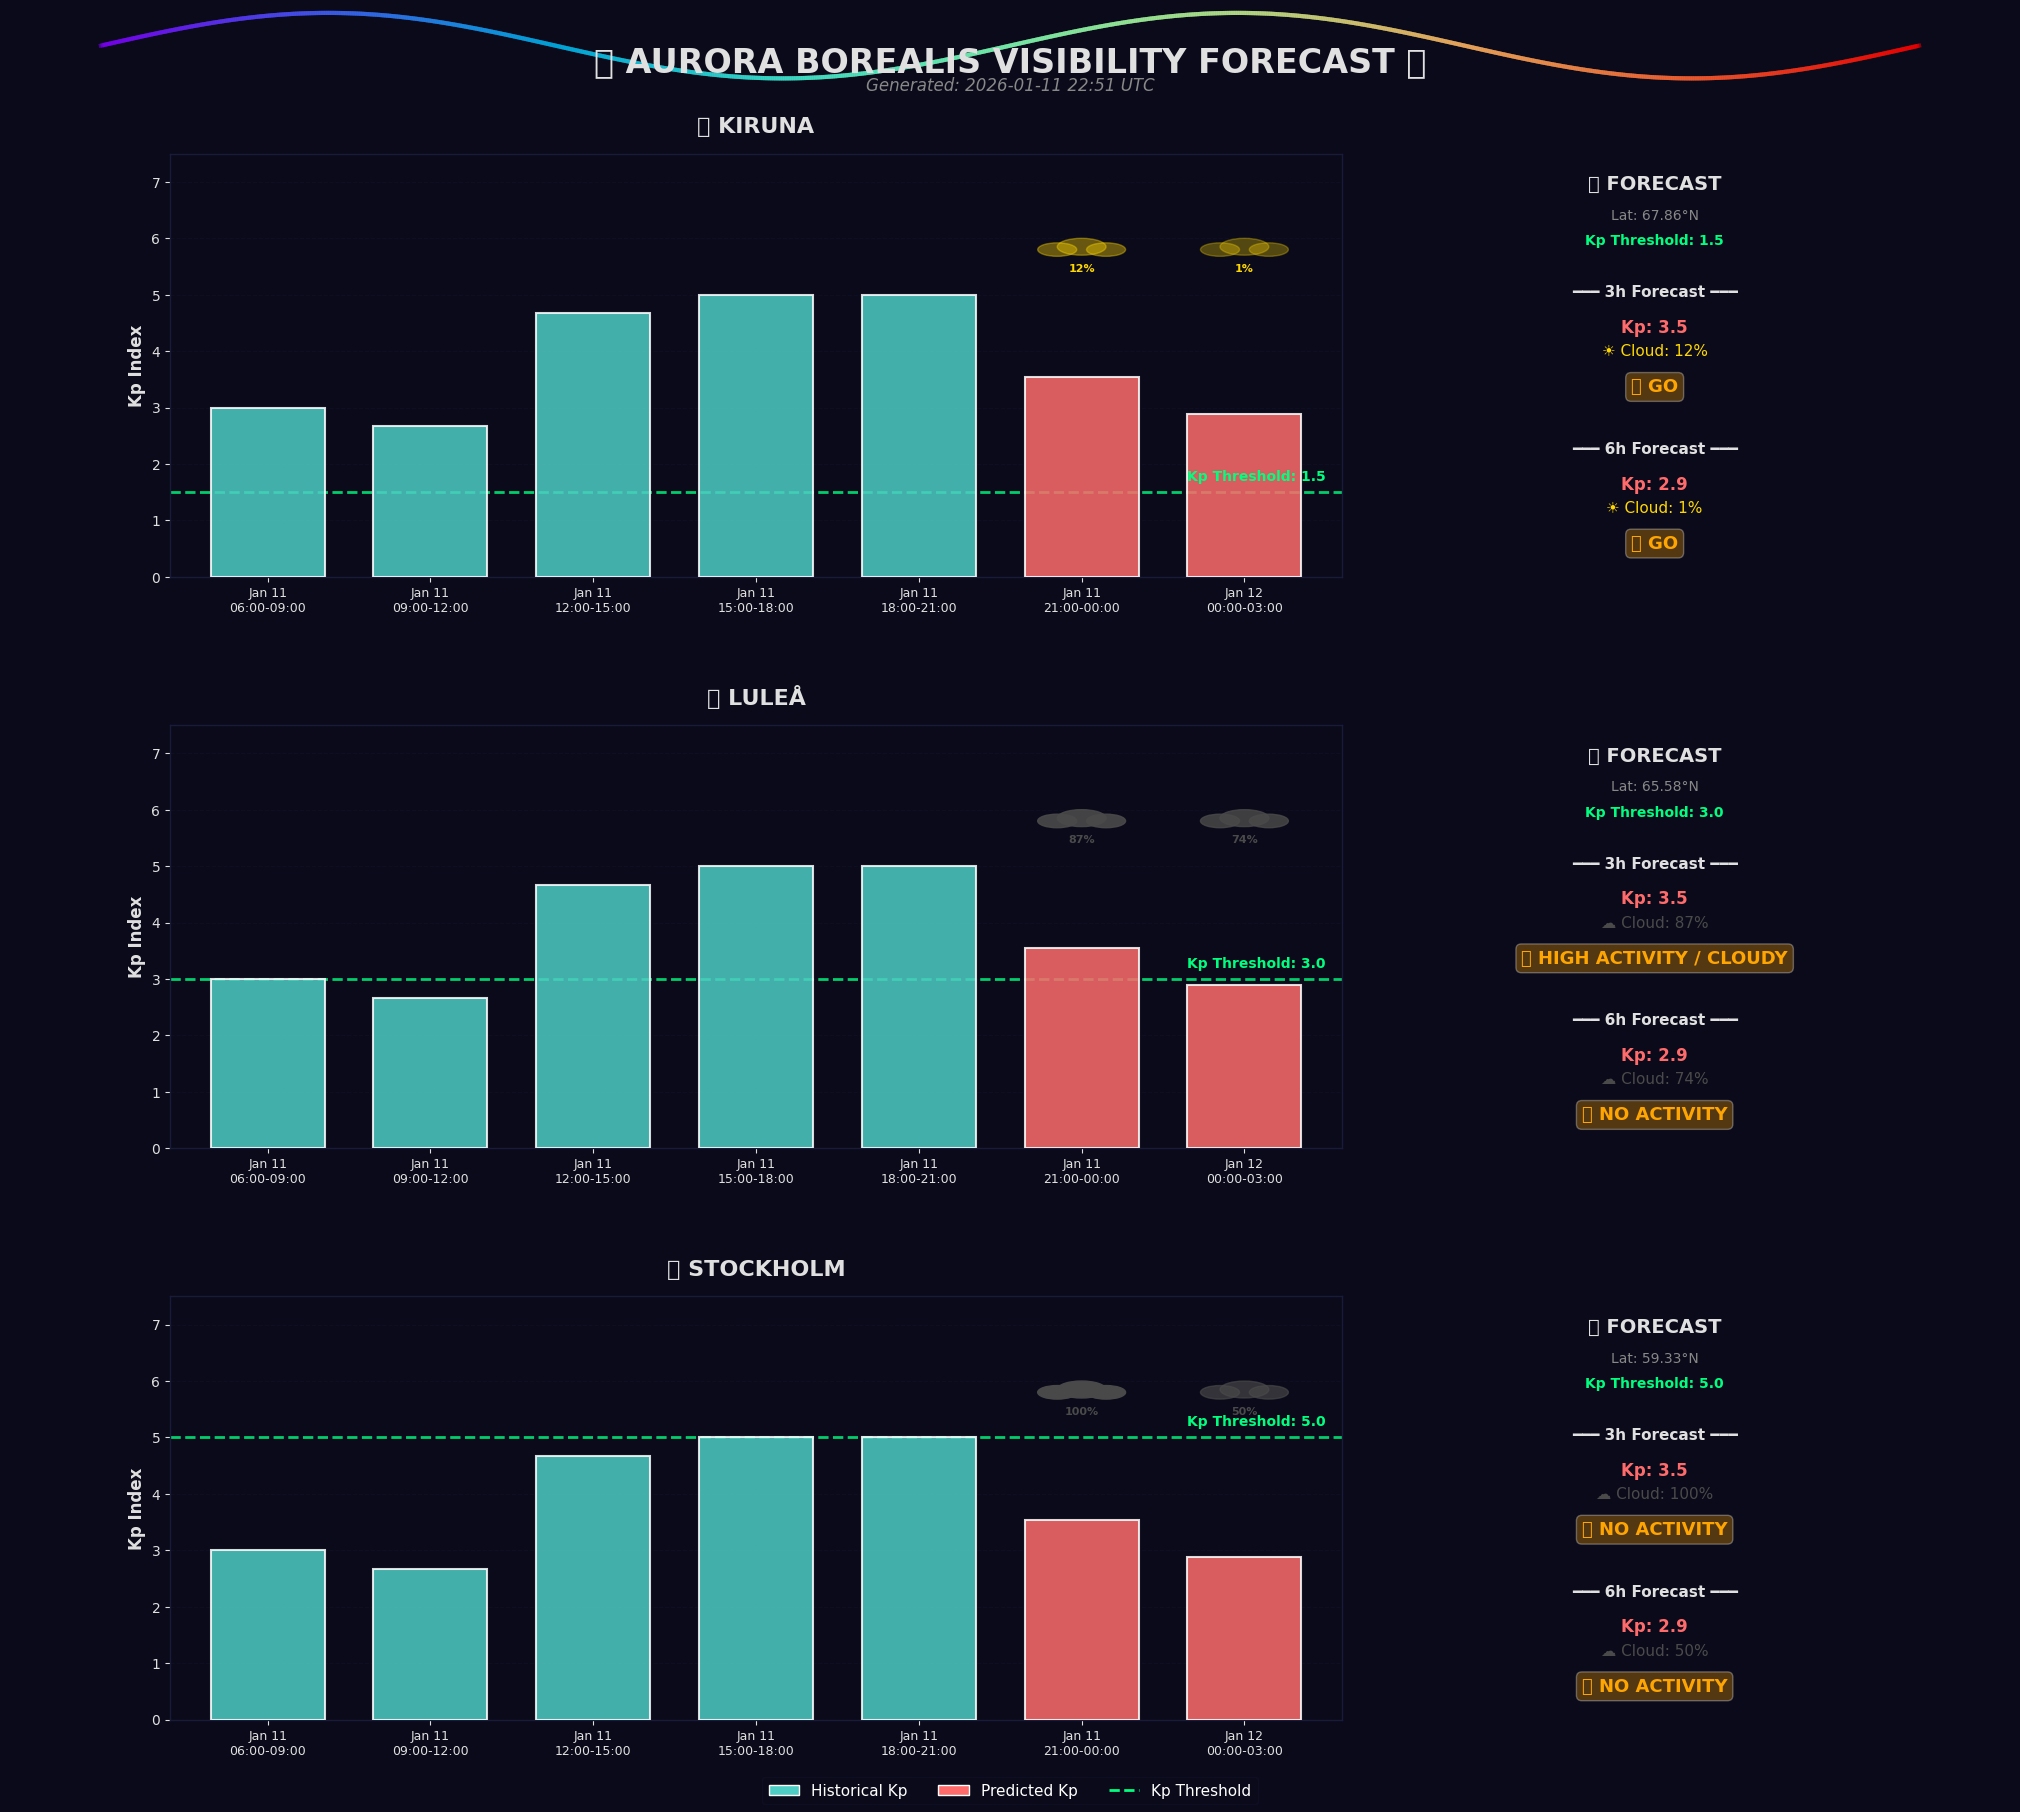

In [32]:
# =============================================================================
# 🌌 AURORA BOREALIS VISIBILITY DASHBOARD 🌌
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import numpy as np
from datetime import datetime

# Set dark theme for space aesthetic
plt.style.use('dark_background')

# Custom color palette
COLORS = {
    'historical': '#4ECDC4',      # Teal for historical Kp
    'predicted': '#FF6B6B',       # Coral for predicted Kp
    'aurora_green': '#00FF7F',    # Aurora green
    'aurora_purple': '#9B59B6',   # Aurora purple
    'cloud_clear': '#FFD700',     # Gold for clear skies
    'cloud_covered': '#4A4A4A',   # Gray for cloudy
    'visible': '#00FF7F',         # Green for visible
    'not_visible': '#FF4757',     # Red for not visible
    'maybe': '#FFA502',           # Orange for maybe
    'background': '#0a0a1a',      # Dark blue-black background
    'grid': '#1a1a3a',            # Subtle grid
    'text': '#E0E0E0',            # Light text
}

# Get historical Kp data (last 5 windows from historical_for_diagram which has kp_index)
historical_df = historical_for_diagram.tail(5).copy()

def format_time_label(start, end):
    """Format time window label for x-axis"""
    if isinstance(start, np.datetime64):
        start = pd.Timestamp(start)
    if isinstance(end, np.datetime64):
        end = pd.Timestamp(end)
    date_str = start.strftime('%b %d')
    start_time = start.strftime('%H:%M')
    end_time = end.strftime('%H:%M')
    return f"{date_str}\n{start_time}-{end_time}"

def get_result_color(result):
    """Get color based on visibility result"""
    if result == "VISIBLE":
        return COLORS['visible']
    elif result == "NOT_VISIBLE":
        return COLORS['not_visible']
    else:
        return COLORS['maybe']

def draw_cloud_indicator(ax, x, cloud_cover, width=0.4, y_base=0):
    """Draw a cloud cover indicator as a stylized cloud icon with fill level"""
    cloud_color = COLORS['cloud_covered'] if cloud_cover > 50 else COLORS['cloud_clear']
    alpha = min(0.3 + (cloud_cover / 100) * 0.7, 1.0)
    
    cloud_y = y_base + 0.3
    
    # Main cloud body (3 overlapping circles)
    circle_params = [
        (x - 0.15, cloud_y, 0.12),
        (x, cloud_y + 0.05, 0.15),
        (x + 0.15, cloud_y, 0.12),
    ]
    
    for cx, cy, r in circle_params:
        circle = Circle((cx, cy), r, color=cloud_color, alpha=alpha, zorder=5)
        ax.add_patch(circle)
    
    # Add cloud cover percentage text
    ax.text(x, cloud_y - 0.25, f'{cloud_cover:.0f}%', 
            ha='center', va='top', fontsize=8, color=cloud_color,
            fontweight='bold', zorder=6)

# Create the main figure
fig = plt.figure(figsize=(20, 18), facecolor=COLORS['background'])
fig.suptitle('🌌 AURORA BOREALIS VISIBILITY FORECAST 🌌', 
             fontsize=24, fontweight='bold', color=COLORS['text'],
             y=0.98)

# Add subtitle with timestamp
current_time = datetime.now().strftime('%Y-%m-%d %H:%M UTC')
fig.text(0.5, 0.955, f'Generated: {current_time}', ha='center', 
         fontsize=12, color='#888888', style='italic')

# Create grid for 3 city panels
gs = gridspec.GridSpec(3, 1, hspace=0.35, top=0.92, bottom=0.05, left=0.08, right=0.92)

cities = list(settings.CITIES.keys())

for idx, city in enumerate(cities):
    city_conf = settings.CITIES[city]
    kp_threshold = city_conf['kp_threshold']
    
    # Get predictions for this city
    city_predictions = inference_df[inference_df['city'] == city].copy()
    
    # Create subplot with inner grid
    inner_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[idx], 
                                                  width_ratios=[3, 1], wspace=0.15)
    
    # Main histogram axis
    ax_hist = fig.add_subplot(inner_gs[0])
    ax_hist.set_facecolor(COLORS['background'])
    
    # Info panel axis
    ax_info = fig.add_subplot(inner_gs[1])
    ax_info.set_facecolor(COLORS['background'])
    ax_info.axis('off')
    
    # Build combined data: Historical (from historical_for_diagram) + Predictions
    x_labels = []
    x_positions = []
    kp_values = []
    bar_colors = []
    cloud_covers = []
    results = []
    is_prediction = []
    
    # Historical data from historical_for_diagram (which has kp_index)
    for i, (_, row) in enumerate(historical_df.iterrows()):
        x_labels.append(format_time_label(row['window_start'], row['window_end']))
        x_positions.append(i)
        kp_values.append(row['kp_index'])
        bar_colors.append(COLORS['historical'])
        cloud_covers.append(None)  # No cloud data for historical
        results.append(None)  # No result for historical
        is_prediction.append(False)
    
    # Current predictions
    pred_start_idx = len(x_positions)
    for i, (_, pred_row) in enumerate(city_predictions.iterrows()):
        x_labels.append(format_time_label(pred_row['prediction_window_start'], 
                                          pred_row['prediction_window_end']))
        x_positions.append(pred_start_idx + i)
        kp_values.append(pred_row['predicted_kp'])
        bar_colors.append(COLORS['predicted'])
        cloud_covers.append(pred_row['cloud_cover_mean'])
        results.append(pred_row['result'])
        is_prediction.append(True)
    
    # Draw bars with gradient effect
    bars = ax_hist.bar(x_positions, kp_values, color=bar_colors, 
                       edgecolor='white', linewidth=1.5, alpha=0.85, width=0.7)
    
    # Add glow effect to bars
    for bar, color in zip(bars, bar_colors):
        bar.set_zorder(3)
    
    # Draw threshold line
    ax_hist.axhline(y=kp_threshold, color=COLORS['aurora_green'], linestyle='--', 
                    linewidth=2, alpha=0.8, zorder=2)
    ax_hist.text(len(x_positions) - 0.5, kp_threshold + 0.15, 
                 f'Kp Threshold: {kp_threshold}', 
                 color=COLORS['aurora_green'], fontsize=10, 
                 fontweight='bold', ha='right', va='bottom')
    
    # Add cloud cover indicators ONLY for predictions (at the top of the plot)
    max_kp = max(kp_values) if kp_values else 5
    y_top = max_kp + 1.5
    
    for i, (cc, is_pred) in enumerate(zip(cloud_covers, is_prediction)):
        if is_pred and cc is not None:
            draw_cloud_indicator(ax_hist, i, cc, y_base=max_kp + 0.5)
    
    # Style the main histogram
    ax_hist.set_xticks(x_positions)
    ax_hist.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=9)
    ax_hist.set_ylabel('Kp Index', fontsize=12, fontweight='bold', color=COLORS['text'])
    ax_hist.set_ylim(0, y_top + 1)
    ax_hist.set_xlim(-0.6, len(x_positions) - 0.4)
    
    # Grid styling
    ax_hist.yaxis.grid(True, linestyle='--', alpha=0.3, color=COLORS['grid'])
    ax_hist.set_axisbelow(True)
    
    # City title with aurora styling
    city_title = f"📍 {city.upper()}"
    ax_hist.set_title(city_title, fontsize=16, fontweight='bold', 
                      color=COLORS['text'], pad=15)
    
    # Spine styling
    for spine in ax_hist.spines.values():
        spine.set_color(COLORS['grid'])
        spine.set_linewidth(1)
    
    ax_hist.tick_params(colors=COLORS['text'])
    
    # =====================
    # INFO PANEL
    # =====================
    panel_y = 0.95
    
    # City info header
    ax_info.text(0.5, panel_y, f"🎯 FORECAST", ha='center', va='top',
                 fontsize=14, fontweight='bold', color=COLORS['text'],
                 transform=ax_info.transAxes)
    
    panel_y -= 0.08
    
    # Latitude info
    ax_info.text(0.5, panel_y, f"Lat: {city_conf['lat']:.2f}°N", ha='center', va='top',
                 fontsize=10, color='#888888', transform=ax_info.transAxes)
    
    panel_y -= 0.06
    ax_info.text(0.5, panel_y, f"Kp Threshold: {kp_threshold}", ha='center', va='top',
                 fontsize=10, color=COLORS['aurora_green'], fontweight='bold',
                 transform=ax_info.transAxes)
    
    panel_y -= 0.12
    
    # Current predictions with visibility badges
    for i, (_, pred_row) in enumerate(city_predictions.iterrows()):
        window = pred_row['window']
        kp = pred_row['predicted_kp']
        cc = pred_row['cloud_cover_mean']
        result = pred_row['result']
        
        result_color = get_result_color(result)
        
        # Window label
        ax_info.text(0.5, panel_y, f"━━━ {window} Forecast ━━━", ha='center', va='top',
                     fontsize=11, fontweight='bold', color=COLORS['text'],
                     transform=ax_info.transAxes)
        panel_y -= 0.08
        
        # Kp value
        ax_info.text(0.5, panel_y, f"Kp: {kp:.1f}", ha='center', va='top',
                     fontsize=12, fontweight='bold', 
                     color=COLORS['predicted'], transform=ax_info.transAxes)
        panel_y -= 0.06
        
        # Cloud cover with icon
        cloud_icon = "☁️" if cc > 50 else "☀️"
        ax_info.text(0.5, panel_y, f"{cloud_icon} Cloud: {cc:.0f}%", ha='center', va='top',
                     fontsize=11, color=COLORS['cloud_clear'] if cc < 50 else COLORS['cloud_covered'],
                     transform=ax_info.transAxes)
        panel_y -= 0.08
        
        # VISIBILITY RESULT - BIG AND BOLD
        result_display = result.replace("_", " ")
        result_icon = "🌌" if result == "VISIBLE" else ("🚫" if result == "NOT_VISIBLE" else "❓")
        
        # Draw a fancy box around the result
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=result_color, 
                         edgecolor='white', alpha=0.3)
        ax_info.text(0.5, panel_y, f"{result_icon} {result_display}", ha='center', va='top',
                     fontsize=13, fontweight='bold', color=result_color,
                     transform=ax_info.transAxes, bbox=bbox_props)
        
        panel_y -= 0.15

# Add legend at bottom
legend_elements = [
    mpatches.Patch(facecolor=COLORS['historical'], edgecolor='white', 
                   label='Historical Kp'),
    mpatches.Patch(facecolor=COLORS['predicted'], edgecolor='white', 
                   label='Predicted Kp'),
    plt.Line2D([0], [0], color=COLORS['aurora_green'], linestyle='--', 
               linewidth=2, label='Kp Threshold'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
           fontsize=11, framealpha=0.3, facecolor=COLORS['background'],
           edgecolor=COLORS['grid'])

# Add decorative aurora wave at top
ax_top = fig.add_axes([0, 0.96, 1, 0.04])
ax_top.axis('off')
x_wave = np.linspace(0, 4*np.pi, 1000)
y_wave = np.sin(x_wave) * 0.3 + 0.5
colors_wave = plt.cm.rainbow(np.linspace(0, 1, len(x_wave)))
for i in range(len(x_wave)-1):
    ax_top.plot(x_wave[i:i+2]/max(x_wave), y_wave[i:i+2], 
                color=colors_wave[i], alpha=0.5, linewidth=3)

plt.savefig('aurora_dashboard.png', dpi=150, facecolor=COLORS['background'], 
            edgecolor='none', bbox_inches='tight')
print("✨ Dashboard saved to 'aurora_dashboard.png'")
plt.show()